In [1582]:
##모듈 불러오기

import pandas as pd
import numpy as np
import datetime as dt
import sklearn

import seaborn as sns
# from pycaret.regression import*
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [1583]:
import os
os.getcwd()

'/Users/admin/PycharmProjects/pythonProject'

In [1584]:
#한글폰트 해결하기

from matplotlib import font_manager, rc

font_path = './malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [1585]:
#seaborn 한글폰트 해결하기
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [1586]:
## 데이터 로드 및 변환 및 feature 생성

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.info()
test.info()

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일

In [1587]:
# Feature extraction


# train
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수'] - (train['본사휴가자수'] + train['본사출장자수'] + train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수'] / train['본사정원수']
train['출장비율'] = train['본사출장자수'] / train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수'] / train['출근']
train['재택비율'] = train['현본사소속재택근무자수'] / train['본사정원수']
train['출장휴가재택비율'] = train['출장비율'] + train['휴가비율'] + train['재택비율']

# test
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수'] - (test['본사휴가자수'] + test['본사출장자수'] + test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수'] / test['본사정원수']
test['출장비율'] = test['본사출장자수'] / test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수'] / test['출근']
test['재택비율'] = test['현본사소속재택근무자수'] / test['본사정원수']
test['출장휴가재택비율'] = test['출장비율'] + test['휴가비율'] + test['재택비율']


In [1588]:
# 요일 분포 보기
train['요일'].value_counts()

3    244
4    242
0    240
1    240
2    239
Name: 요일, dtype: int64

In [1589]:
test['요일'].value_counts()

2    11
3    10
4    10
1    10
0     9
Name: 요일, dtype: int64

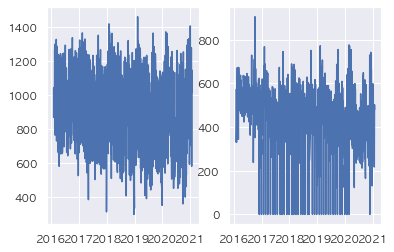

In [1590]:
# 식수인원 plot

plt.subplot(1,2,1)
plt.plot(train['일자'], train['중식계'])

plt.subplot(1,2,2)
plt.plot(train['일자'], train['석식계'])

plt.show()

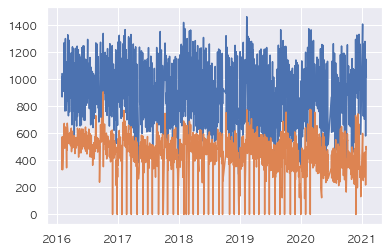

In [1591]:
plt.plot(train['일자'], train['중식계'])
plt.plot(train['일자'], train['석식계'])

plt.show()


## 중식인원과 석식인원 사이에 확연한 차이가 있다는 것을 알 수 있다. 모델을 다르게 설정해야함

In [1592]:
# 외부데이터 가지고 오기

# 기상데이터 가지고 오기(12시에 비 온 데이터 one_hot encoding)(비가 오면 아무래도 사람들이 밖에나가서 밥을 먹기보다는 구내식당에서 밥을 먹을 가능성이 높다는 가정)

rain_train = pd.read_csv("./rain_train.csv")

rain_train['날짜'] = pd.to_datetime(rain_train['일시'])
rain_train['년'] = rain_train['날짜'].dt.year
rain_train['월'] = rain_train['날짜'].dt.month
rain_train['일'] = rain_train['날짜'].dt.day
rain_train['시간'] = rain_train['날짜'].dt.hour

rain_train['TF'] = np.where((rain_train['시간']==12) & (rain_train.iloc[:,3]>=3),1,0)

rain_12 = rain_train[(rain_train['시간']==12)].loc[:, ['년', '월', '일', 'TF']]

train_rain = pd.merge(train, rain_12, on=['년', '월', '일'], how='left')

train_rain.rename(columns={"TF_x":"TF"}, inplace=True)
train = train_rain

# test 데이터 기상데이터 one_hot encoding
rain_test = pd.read_csv("./rain_test.csv")
rain_test
rain_test['날짜'] = pd.to_datetime(rain_test['일시'])
rain_test['년'] = rain_test['날짜'].dt.year
rain_test['월'] = rain_test['날짜'].dt.month
rain_test['일'] = rain_test['날짜'].dt.day
rain_test['시간'] = rain_test['날짜'].dt.hour


rain_test['TF'] = np.where((rain_test['시간']==12) & (rain_test.iloc[:,3]>=3),1,0)

rain_12 = rain_test[(rain_test['시간']==12)].loc[:, ['년', '월', '일', 'TF']]

test_rain = pd.merge(test, rain_12, on=['년', '월', '일'], how='left')

test_rain.rename(columns={"TF_x":"TF"}, inplace=True)
test = test_rain


In [1593]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '출장휴가재택비율', 'TF'],
      dtype='object')

In [1594]:
# 외부데이터 가지고 오기

# 온도 데이터 불러오기

temp = pd.read_csv("./highest_temp.csv")
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp['년'] = temp['날짜'].dt.year
temp['월'] = temp['날짜'].dt.month
temp['일'] = temp['날짜'].dt.day

temp_train = temp[['년', '월', '일', '최고기온(℃)']]
temp_train.rename(columns={'최고기온(℃)':'최고기온'}, inplace = True)
train_temp = pd.merge(train, temp_train, on=['년', '월', '일'], how='left')
train = train_temp


temp = pd.read_csv("./highest_temp.csv")
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp['년'] = temp['날짜'].dt.year
temp['월'] = temp['날짜'].dt.month
temp['일'] = temp['날짜'].dt.day

temp_test = temp[['년', '월', '일', '최고기온(℃)']]
temp_test.rename(columns={'최고기온(℃)':'최고기온'}, inplace = True)

test_temp = pd.merge(test, temp_test, on=['년', '월', '일'], how='left')
test = test_temp

In [1595]:
# 야근에 대한 정보 추출

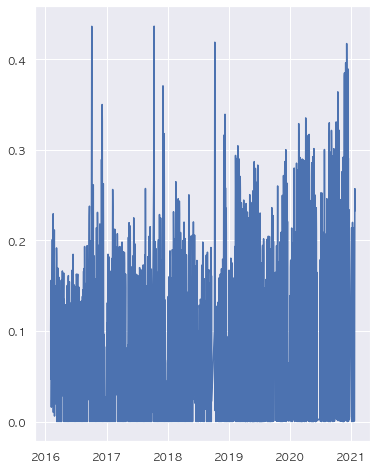

In [1596]:
plt.figure(figsize=(6,8))
plt.plot(train['일자'],train['야근비율'])

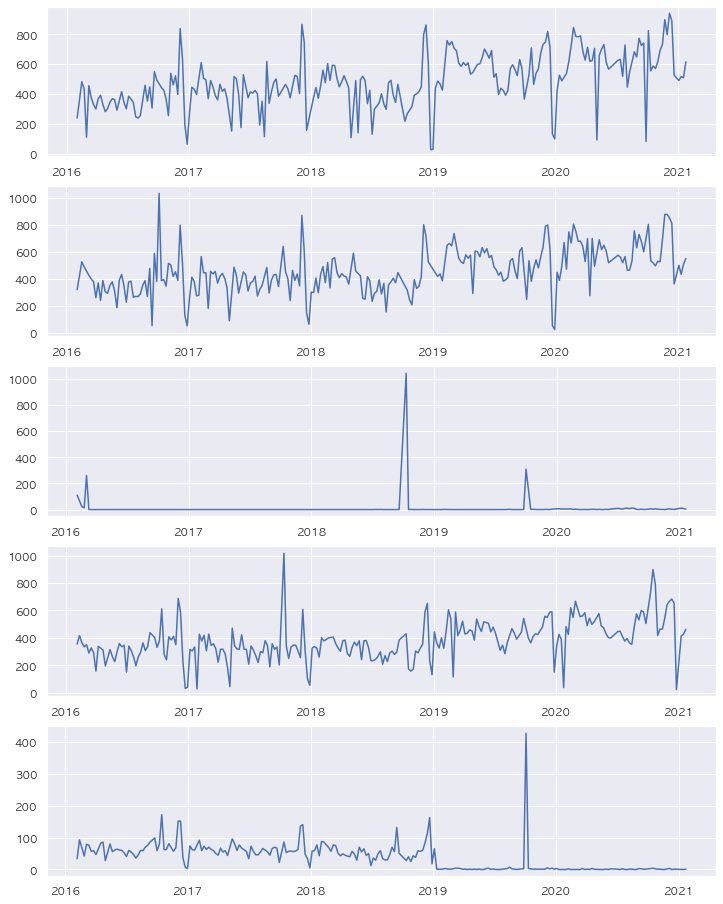

In [1597]:
plt.figure(figsize = (12,16))

train1 = train[train['요일']==0]
plt.subplot(5,1,1)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])


train1 = train[train['요일']==1]
plt.subplot(5,1,2)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])


train1 = train[train['요일']==2]
plt.subplot(5,1,3)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])

train1 = train[train['요일']==3]
plt.subplot(5,1,4)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])

train1 = train[train['요일']==4]
plt.subplot(5,1,5)
plt.plot(train1['일자'],train1['본사시간외근무명령서승인건수'])
plt.show()

2019년부터 금요일 야근이 확 줄었다.
또한 금요일 그래프에서 아주 극단적인 수치가 나타는데 이를 처리해줘야 할 것.

In [1598]:
# 2019년부터 금요일 야근이 확 줄었다.


train['overwork'] = np.where((train['년'] >= 2019) & (train['요일'] == 4),1,0)
train_overwork = train.loc[:, ['년', '월', '일', 'overwork']]
train_overwork1 = pd.merge(train, train_overwork, on=['년', '월', '일'], how='left')
train_overwork1.rename(columns={"overwork_x":"overwork"}, inplace=True)
train = train_overwork1.iloc[:,0:-1]


test['overwork'] = np.where((test['년'] >= 2019) & (test['요일'] == 4),1,0)
test_overwork = test.loc[:, ['년', '월', '일', 'overwork']]
test_overwork1 = pd.merge(test, test_overwork, on=['년', '월', '일'], how='left')
test_overwork1.rename(columns={"overwork_x":"overwork"}, inplace=True)
test = test_overwork1.iloc[:,0:-1]


In [1599]:
train[(train['요일']==4) & (train['본사시간외근무명령서승인건수']>300)]
# 금요일 300명 이상이 야근 승인을 받은 것은 매우 특이한 케이스이므로 이를 어떻게 처리해야 할지 생각해야 할 것.

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,주,출근,휴가비율,출장비율,야근비율,재택비율,출장휴가재택비율,TF,최고기온,overwork
895,2019-10-04,4,3121,268,231,428,0,모닝롤/치즈프레즐 우유/주스 계란후라이 홍게살죽/쌀밥 (쌀:국내산) 황태국 쥐포...,쌀밥/잡곡밥 (쌀:국내산) 해물된장찌개 소불고기 두부양념조림 미역레몬초무침 ...,쌀밥/잡곡밥 (쌀:국내산) 순두부찌개 함박스테이크 계란찜 콩나물무침 포기김치...,...,40,2622,0.08587,0.074015,0.163234,0.0,0.159885,NaN,27.6,1


In [1600]:
# 코로나 상황 고려
# 2020년 02월 27일부로 재택근무가 시작되었다.

train['home'] = np.where((train['일자'] >= "2020-02-26"),1,0)
train_home = train.loc[:, ['년', '월', '일', 'home']]
train_home1 = pd.merge(train, train_home, on=['년', '월', '일'], how='left')
train_home1.rename(columns={'home_x':'home'},inplace=True)
train = train_home1.iloc[:,:-1]

test['home'] = 1

In [1601]:
# 단순 반복 작업 (공휴일 전후, 전전, 후후, 퐁당퐁당 공휴일 변수화하기)

## 공휴일 전/후 데이터 추가 연휴 바로 전 평일 1 / 휴일 다음 날 평일 2 / 휴일 다음다음날3 / 휴일 전전날 4 / 퐁당퐁당 5

train['공휴일전후'] = 0
test['공휴일전후'] = 0
train['공휴일전후'][4] = 1
train['공휴일전후'][5] = 2
train['공휴일전후'][6] = 3
train['공휴일전후'][17] = 5
train['공휴일전후'][18] = 2
train['공휴일전후'][47] = 1
train['공휴일전후'][48] = 2
train['공휴일전후'][62] = 1
train['공휴일전후'][63] = 2
train['공휴일전후'][82] = 1
train['공휴일전후'][83] = 2
train['공휴일전후'][131] = 1
train['공휴일전후'][132] = 2
train['공휴일전후'][151] = 4
train['공휴일전후'][152] = 1
train['공휴일전후'][153] = 2
train['공휴일전후'][162] = 1
train['공휴일전후'][163] = 2
train['공휴일전후'][244] = 4
train['공휴일전후'][245] = 1
train['공휴일전후'][246] = 2
train['공휴일전후'][247] = 3
train['공휴일전후'][266] = 1
train['공휴일전후'][267] = 2
train['공휴일전후'][308] = 4
train['공휴일전후'][309] = 1
train['공휴일전후'][310] = 5
train['공휴일전후'][311] = 5
train['공휴일전후'][312] = 2
train['공휴일전후'][330] = 5
train['공휴일전후'][331] = 2
train['공휴일전후'][379] = 5
train['공휴일전후'][380] = 2
train['공휴일전후'][411] = 4
train['공휴일전후'][412] = 1
train['공휴일전후'][413] = 2
train['공휴일전후'][414] = 3
train['공휴일전후'][466] = 1
train['공휴일전후'][467] = 2
train['공휴일전후'][470] = 1
train['공휴일전후'][471] = 2
train['공휴일전후'][501] = 4
train['공휴일전후'][502] = 1
train['공휴일전후'][503] = 2
train['공휴일전후'][510] = 1
train['공휴일전후'][511] = 5
train['공휴일전후'][555] = 1
train['공휴일전후'][556] = 2
train['공휴일전후'][565] = 5
train['공휴일전후'][566] = 2
train['공휴일전후'][575] = 1
train['공휴일전후'][576] = 2
train['공휴일전후'][579] = 1
train['공휴일전후'][580] = 2
train['공휴일전후'][623] = 1
train['공휴일전후'][624] = 2
train['공휴일전후'][650] = 1
train['공휴일전후'][651] = 5
train['공휴일전후'][652] = 2
train['공휴일전후'][653] = 3
train['공휴일전후'][705] = 5
train['공휴일전후'][706] = 2
train['공휴일전후'][709] = 5
train['공휴일전후'][710] = 2
train['공휴일전후'][732] = 1
train['공휴일전후'][733] = 2
train['공휴일전후'][734] = 1
train['공휴일전후'][748] = 1
train['공휴일전후'][749] = 2
train['공휴일전후'][791] = 2
train['공휴일전후'][792] = 1
train['공휴일전후'][793] = 2
train['공휴일전후'][814] = 4
train['공휴일전후'][815] = 5
train['공휴일전후'][862] = 4
train['공휴일전후'][864] = 5
train['공휴일전후'][881] = 4
train['공휴일전후'][882] = 1
train['공휴일전후'][883] = 2
train['공휴일전후'][897] = 1

train['공휴일전후'][950] = 4
train['공휴일전후'][951] = 1
train['공휴일전후'][952] = 2
train['공휴일전후'][955] = 1
train['공휴일전후'][956] = 2
train['공휴일전후'][970] = 4
train['공휴일전후'][971] = 1
train['공휴일전후'][972] = 2
train['공휴일전후'][973] = 3
train['공휴일전후'][1027] = 1
train['공휴일전후'][1028] = 2
train['공휴일전후'][1036] = 4
train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 5
train['공휴일전후'][1039] = 2
train['공휴일전후'][1099] = 1
train['공휴일전후'][1100] = 2
train['공휴일전후'][1029] = 1
train['공휴일전후'][1030] = 2
train['공휴일전후'][1129] = 4
train['공휴일전후'][1133] = 1
train['공휴일전후'][1134] = 2
train['공휴일전후'][1186] = 4
train['공휴일전후'][1187] = 1
train['공휴일전후'][1188] = 2
test['공휴일전후'][9] = 4
test['공휴일전후'][10] = 1
test['공휴일전후'][11] = 2
test['공휴일전후'][20] = 1
test['공휴일전후'][21] = 2


In [1602]:
train['공휴일전후'].unique()

array([0, 1, 2, 3, 5, 4])

In [1603]:
a = train[train['공휴일전후']==0].loc[:,'중식계'].mean()
b = train[train['공휴일전후']==1].loc[:,'중식계'].mean()
c = train[train['공휴일전후']==2].loc[:,'중식계'].mean()
d = train[train['공휴일전후']==3].loc[:,'중식계'].mean()
e = train[train['공휴일전후']==4].loc[:,'중식계'].mean()
f = train[train['공휴일전후']==5].loc[:,'중식계'].mean()

In [1604]:
print( f'휴일을 공휴하지 않는 날의 중식계 평균은 {a} 이고 연휴 전날의 중식계 평균은 {b}, 연휴 다음날은 {c}, 연휴 다음다음날은 {d}, 연휴 전전날은 {e}, 퐁당퐁당인 날은 {f}') 

휴일을 공휴하지 않는 날의 중식계 평균은 892.1845454545454 이고 연휴 전날의 중식계 평균은 746.1428571428571, 연휴 다음날은 1092.2564102564102, 연휴 다음다음날은 1137.2, 연휴 전전날은 740.1538461538462, 퐁당퐁당인 날은 571.4615384615385


즉, 연휴 전날에는 휴가를 쓰는 직원들이 많고 이에 따라 식수 인원이 줄어드는 경우가 많다. 반대로 연휴가 끝나고 난 직후에는 직원들이 중식당을 평균적으로 많이 찾는다. 특히 퐁당으로 휴일과 휴일 사이에 평일이 하루 끼어있는 경우에는 중식계 평균인원이 급격하게 줄어드는 양상을 보인다.

In [1605]:
# 코로나로 인해 경각심을 가지는 시기 (20년 2말 / 20년 8말 / 20년 12월 1월초) #코로나 확진자 수가 급증하며 확진자수에 대한 대중의 관심이 커지는 시점
# mask_covid = (((train['년'] == 2020) & (train['월']==2) & (train['일'] >= 24)) |  ((train['년'] == 2020) & (train['월']==3) & (train['일'] <= 10)) | ((train['년'] == 2020) & (train['월']==8) & (train['일'] >= 24)) |  ((train['년'] == 2020) & (train['월']==9) & (train['일'] <= 10)) | ((train['년'] == 2020) & (train['월']==11) & (train['일'] >= 23)) |  ((train['년'] == 2020) & (train['월']==12) & (train['일'] <= 23))) | ((train['년'] == 2021) & (train['월']==1) & (train['일'] >=4))

mask_covid = (((train['년'] == 2020) & (train['월'] == 2) & (train['일'] >= 24)) | (
            (train['년'] == 2020) & (train['월'] == 3) & (train['일'] <= 10)) | (
                          (train['년'] == 2020) & (train['월'] == 8) & (train['일'] >= 24)) | (
                          (train['년'] == 2020) & (train['월'] == 9) & (train['일'] <= 10)) | (
                          (train['년'] == 2020) & (train['월'] == 11) & (train['일'] >= 19)) | (
                          (train['년'] == 2020) & (train['월'] == 12) & (train['일'] <= 24))) | (
                         (train['년'] == 2021) & (train['월'] == 1) & (train['일'] >= 4))

train_covid = train[mask_covid]
train_covid
train_covid['covid'] = 1
train_covid = train_covid.loc[:, ['년', '월', '일', 'covid']]
train_covid1 = pd.merge(train, train_covid, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
train_covid1.dropna(subset=['요일'], axis=0, inplace=True)
train_covid1['covid'].replace(np.nan, 0, inplace=True)
train = train_covid1
train

test.columns

mask_covid_t = (((test['년'] == 2021) & (test['월'] == 1) & (test['일'] >= 27)) & (
            (test['년'] == 2021) & (test['월'] == 1) & (test['일'] <= 29))) | (
                           ((test['년'] == 2021) & (test['월'] == 2) & (test['일'] >= 15)) & (
                               (test['년'] == 2021) & (test['월'] == 2) & (test['일'] <= 23))) | (
                           ((test['년'] == 2021) & (test['월'] == 4) & (test['일'] >= 6)) & (
                               (test['년'] == 2021) & (test['월'] == 4) & (test['일'] <= 9)))

test_covid = test[mask_covid_t]
test_covid
test_covid['covid'] = 1
test_covid = test_covid.loc[:, ['년', '월', '일', 'covid']]
test_covid1 = pd.merge(test, test_covid, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
test_covid1.dropna(subset=['요일'], axis=0, inplace=True)
test_covid1['covid'].replace(np.nan, 0, inplace=True)
test = test_covid1



In [1606]:
# 과거 매달 마지막 주 수요일 문화의 날 행사 원핫인코딩 / test 데이터에서는 자기계발의 날이 없는것으로 보아 현재는 시행 안하는듯.

train['culture'] = np.where(train['석식계'] == 0,1,0)
train_culture = train.loc[:, ['년', '월', '일', 'culture']]
train_culture1 = pd.merge(train, train_culture, on=['년', '월', '일'], how='left')
train_culture1.rename(columns={'culture_x':'culture'},inplace=True)
train = train_culture1.iloc[:,:-1]


test['culture'] = 0

In [1607]:
# 연말연초에는 약속이 많다

mask_alcho = ((train['년'] == 2016) & (train['월'] == 12) & (train['일'] >= 22)) & (
            (train['년'] == 2016) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2017) & (train['월'] == 12) & (train['일'] >= 22)) & (
                         (train['년'] == 2017) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2018) & (train['월'] == 12) & (train['일'] >= 20)) & (
                         (train['년'] == 2018) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2019) & (train['월'] == 12) & (train['일'] >= 20)) & (
                         (train['년'] == 2019) & (train['월'] == 12) & (train['일'] <= 31)) | (
                         (train['년'] == 2020) & (train['월'] == 12) & (train['일'] >= 22)) & (
                         (train['년'] == 2020) & (train['월'] == 12) & (train['일'] <= 31))

train_alcho = train[mask_alcho]
train_alcho['일자']
train_alcho['alcho'] = 1
train_alcho = train_alcho.loc[:, ['년', '월', '일', 'alcho']]
train_alcho1 = pd.merge(train, train_alcho, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='outer')
train_alcho1.dropna(subset=['요일'], axis=0, inplace=True)
train_alcho1['alcho'].replace(np.nan, 0, inplace=True)
train = train_alcho1
train

test['alcho'] = 0


In [1608]:
train.shape

(1205, 30)

In [1609]:
# 서울시 코로나 확진자 데이터 가져오기

covid = pd.read_csv("./covid.csv")
covid['확진일'] = pd.to_datetime(covid['확진일'])

covid['확진자수'] = 1
covid = covid[['확진일', '확진자수']]
covid1 = covid.groupby(['확진일']).sum()
covid1.reset_index(inplace=True)

datee = pd.date_range('2016-02-01', '2021-04-09')
datee = pd.DataFrame(datee)
datee.rename(columns={0:'날짜'},inplace=True)
covid2 = pd.merge(datee, covid1, left_on=['날짜'],right_on=['확진일'], how='left')



covid3 = covid2[covid2['날짜'].notnull()]
covid3['날짜'] = pd.to_datetime(covid3['날짜'])
covid3['년'] = covid3['날짜'].dt.year
covid3['월'] = covid3['날짜'].dt.month
covid3['일'] = covid3['날짜'].dt.day
covid3 = covid3[['년','월','일', '확진자수']]
covid3['확진자수'].replace(np.nan, 0, inplace=True)

train = pd.merge(train, covid3, on=['년', '월', '일'], how='left')
train.rename(columns={'확진자수_x':'확진자수'},inplace=True)

test = pd.merge(test, covid3, left_on=['년', '월', '일'], right_on=['년', '월', '일'], how='left')
test.rename(columns={'확진자수_x':'확진자수'},inplace=True)


## 데이터 transformation 및 스케일링

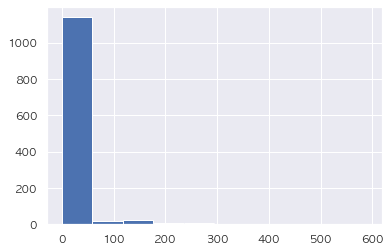

In [1610]:
plt.hist(train['확진자수'])
plt.show()

왜도가 크기 때문에, 확진자수 데이터에 대한 로그변환이 필요할듯.

In [1611]:
#확진자수 로그변환

train['확진자수_log'] = np.log1p(train['확진자수'])
test['확진자수_log'] = np.log1p(test['확진자수'])

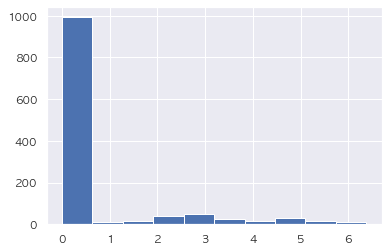

In [1612]:
plt.hist(train['확진자수_log'])
plt.show()

In [1613]:
# 서울시 확진자수 minmaxscaler

minmax = StandardScaler()
total = np.array(train['확진자수_log'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['확진자수_log_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['확진자수_log'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['확진자수_log_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')

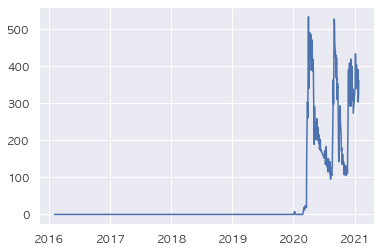

In [1614]:
plt.plot(train['일자'], train['현본사소속재택근무자수'])
plt.show()

In [1615]:
# 현본사소속재택근무자수 minmax scale 하기 (0의 값이 매우 많기 때문에 standardscaler보다는 minmaxscaler를 쓰는게 낫다)

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
total = np.array(train['현본사소속재택근무자수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['현본사소속재택근무자수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['현본사소속재택근무자수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['현본사소속재택근무자수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')


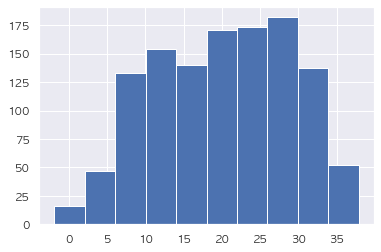

In [1616]:
plt.hist(train['최고기온'])
plt.show()

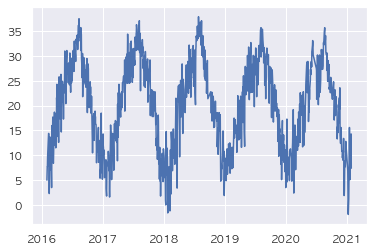

In [1617]:
plt.plot(train['일자'],train['최고기온'])
plt.show()

In [1618]:
# 전주시 최고기온 standardscaler(이상치가 그리 크지 않기 때문에 정규화시킴)

from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['최고기온'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['최고기온_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')

total_test = np.array(test['최고기온'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['최고기온_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')

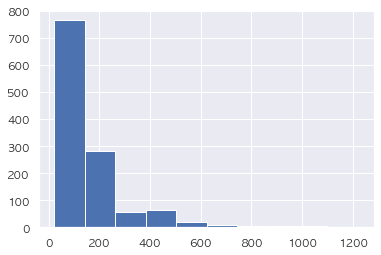

In [1619]:
plt.hist(train['본사휴가자수'])
plt.show()

In [1620]:
train['본사휴가자수_log'] = np.log1p(train['본사휴가자수'])
test['본사휴가자수_log'] = np.log1p(test['본사휴가자수'])

In [1621]:
# 본사 정원수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['출근'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['출근_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"출근_scale_x":"출근"}, inplace = True)

total_test = np.array(test['출근'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['출근_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"출근_scale_x":"출근"}, inplace = True)


# 본사 휴가자수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사휴가자수_log'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사휴가자수_log_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사휴가자수_log_scale_x":"본사휴가자수_log_scale"}, inplace = True)

total_test = np.array(test['본사휴가자수_log'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사휴가자수_log_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사휴가자수_log_scale_x":"본사휴가자수_log_scale"}, inplace = True)

# 본사출장자수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사출장자수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사출장자수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사출장자수_scale_x":"본사출장자수_scale"}, inplace = True)

total_test = np.array(test['본사출장자수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사출장자수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사출장자수_scale_x":"본사출장자수_scale"}, inplace = True)

# 본사시간외근무명령서승인건수 minmax scale 하기
from sklearn.preprocessing import StandardScaler

minmax = StandardScaler()
total = np.array(train['본사시간외근무명령서승인건수'])
total = total.reshape(-1, 1)
minmax.fit(total)
total = minmax.transform(total)
total = pd.DataFrame(total, columns=['본사시간외근무명령서승인건수_scale'])
train = pd.merge(train, total, left_index=True, right_index=True, how='left')
train.rename(columns={"본사시간외근무명령서승인건수_scale_x":"본사시간외근무명령서승인건수_scale"}, inplace = True)

total_test = np.array(test['본사시간외근무명령서승인건수'])
total_test = total_test.reshape(-1, 1)
total_test = minmax.transform(total_test)
total_test = pd.DataFrame(total_test, columns=['본사시간외근무명령서승인건수_scale'])
test = pd.merge(test, total_test, left_index=True, right_index=True, how='left')
test.rename(columns={"본사시간외근무명령서승인건수_scale_x":"본사시간외근무명령서승인건수_scale"}, inplace = True)



In [1622]:
# corr 파일에서 본 상관계수가 높은 변수 만들어내기

train['휴가ls2시간외s'] = (train['본사휴가자수_log_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['최고기온s2시간외s'] = (train['최고기온_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['시간외s3'] = (train['본사시간외근무명령서승인건수_scale']) ** 3
train['출장자수s2시간외s'] = (train['본사출장자수_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])
train['출근s2시간외s'] = (train['출근_scale'] ** 2) * (train['본사시간외근무명령서승인건수_scale'])

test['휴가ls2시간외s'] = (test['본사휴가자수_log_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['최고기온s2시간외s'] = (test['최고기온_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['시간외s3'] = (test['본사시간외근무명령서승인건수_scale']) ** 3
test['출장자수s2시간외s'] = (test['본사출장자수_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])
test['출근s2시간외s'] = (test['출근_scale'] ** 2) * (test['본사시간외근무명령서승인건수_scale'])


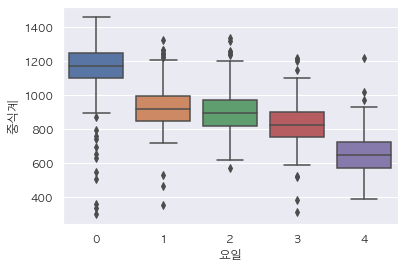

In [1623]:
sns.boxplot(x='요일', y='중식계', data=train)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fccfd0ad910>,
 'caps': [<matplotlib.lines.Line2D at 0x7fccfd60b070>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccfd0ad580>],
 'medians': [<matplotlib.lines.Line2D at 0x7fccfd60b790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fccfd60bb20>],
 'means': []}

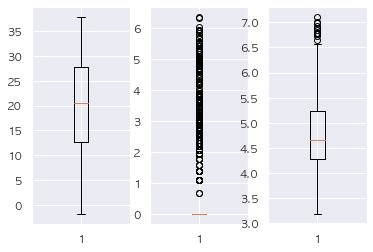

In [1624]:
# 이상치제거
plt.subplot(1,3,1)
plt.boxplot(train.최고기온)
plt.subplot(1,3,2)
plt.boxplot(train.확진자수_log)
plt.subplot(1,3,3)
plt.boxplot(train.본사휴가자수_log)

<AxesSubplot:xlabel='요일', ylabel='본사시간외근무명령서승인건수'>

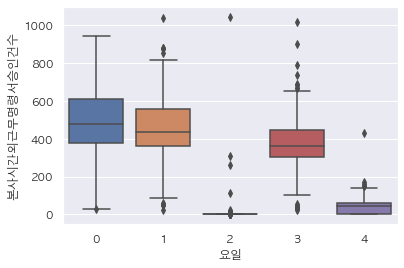

In [1625]:
sns.boxplot(x='요일', y='본사시간외근무명령서승인건수', data = train)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fccfd68fa60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fccfb3d9d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccfd68f310>],
 'medians': [<matplotlib.lines.Line2D at 0x7fccfd689130>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fccfd6892e0>],
 'means': []}

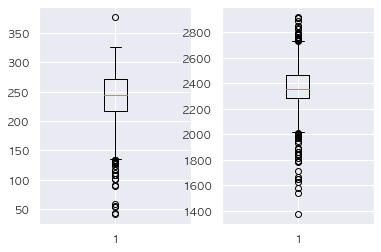

In [1626]:
plt.subplot(1,2,1)
plt.boxplot(train.본사출장자수)
plt.subplot(1,2,2)
plt.boxplot(train.출근)

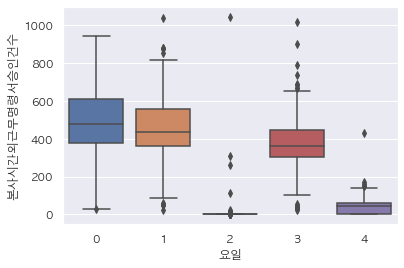

In [1627]:
# IQR을 사용해서 이상치 제거하기
sns.boxplot(x='요일', y='본사시간외근무명령서승인건수', data=train)

# 월
iqr = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 0].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 0].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 0].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 0][mask_time]
List = list(train_outliers.index)
List  # 705 실제 train 데이터에서 엑셀 기준 707

for i in List:
    train.drop(index=i, inplace=True)

# 화 (실제로 예측해야할 데이터들이 화요일에 야근이 많다 따라서 크다고 여겨지는 이상치는 이상치가 아니다)
iqr = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 1].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 1].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 1][mask_time]
List = list(train_outliers.index)
List  # 152, 163, 223, 453*, 467, 951, 955, 1165*, 1170*, 1175* *별표는 큰 이상치

for i in List:
    train.drop(index=i, inplace=True)

# 수
iqr = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 2].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 2].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 2].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 2][mask_time]
List = list(train_outliers.index)
List  # 세자리, 네자리 수인 2,9,14,18 만 지우겠다.

train.drop(index=2, inplace=True)
train.drop(index=18, inplace=True)
train.drop(index=652, inplace=True)
train.drop(index=894, inplace=True)

# 목
iqr = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 3].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 3].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 3][mask_time]
List = list(train_outliers.index)  # TESTSET에 746 정도가 있기 때문에 매우 작은 것과 800 이상의 점 두개를 지운다.
List

for i in List:
    train.drop(index=i, inplace=True)

mask_time = (train[train['요일'] == 3].본사시간외근무명령서승인건수 > upper)
train_outliers = train[train['요일'] == 3][mask_time]
List = list(train_outliers.index)  # TESTSET에 746 정도가 있기 때문에 매우 작은 것과 800 이상의 점 두개를 지운다.
List  # 415, 1137

train.drop(index=415, inplace=True)
train.drop(index=1137, inplace=True)

# 금
iqr = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.75) - np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수,
                                                                              0.25)
iqr * 1.5
upper = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.75) + iqr * 1.5
lower = np.quantile(train[train['요일'] == 4].본사시간외근무명령서승인건수, 0.25) - iqr * 1.5
mask_time = (train[train['요일'] == 4].본사시간외근무명령서승인건수 > upper) | (train[train['요일'] == 4].본사시간외근무명령서승인건수 < lower)
train_outliers = train[train['요일'] == 4][mask_time]
List = list(train_outliers.index)
List  # 400이상인 895번 index만 삭제한다.

train.drop(index=895, inplace=True)

train_lunch = train
train_dinner = train
test_lunch = test
test_dinner = test

# train dinner에서 결측치 이상치 제거하기

mask_oo = train_dinner['일자'] != '2017-09-27'
train_dinner = train_dinner[mask_oo]
mask_ooo = train_dinner['일자'] != '2018-02-14'
train_dinner = train_dinner[mask_ooo]
train_dinner

mask_0 = train_dinner['석식계'] != 0
train_dinner = train_dinner[mask_0]
train_dinner

mask_0 = train_dinner['석식계']!=0
train_dinner = train_dinner[mask_0]
train_dinner
 
train_dinner['야근제외석식'] = train_dinner['석식계']-train_dinner['본사시간외근무명령서승인건수']
#plt.plot(train_dinner.index, train_dinner.야근제외석식)
 
train_dinner['석식계'].skew()
train_dinner['석식계'].kurt()
#plt.hist(train_dinner['석식계'], bins=15, alpha=0.5)
 
 
 
#월화목/ 수금 분리

mask_day = (train_dinner['요일']==0) |  (train_dinner['요일']==1) | (train_dinner['요일']==3)  
train_dinner_mtt = train_dinner[mask_day]
 
mask_day = (train_dinner['요일']==2) |  (train_dinner['요일']==4)   
train_dinner_wf = train_dinner[mask_day]

mask_day = (test_dinner['요일']==0) |  (test_dinner['요일']==1) | (test_dinner['요일']==3)  
test_dinner_mtt = test_dinner[mask_day]
 
mask_day = (test_dinner['요일']==2) |  (test_dinner['요일']==4)   
test_dinner_wf = test_dinner[mask_day]


In [1628]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '출장휴가재택비율', 'TF', '최고기온',
       'overwork', 'home', '공휴일전후', 'covid', 'culture', 'alcho', '확진자수',
       '확진자수_log', '확진자수_log_scale', '현본사소속재택근무자수_scale', '최고기온_scale',
       '본사휴가자수_log', '출근_scale', '본사휴가자수_log_scale', '본사출장자수_scale',
       '본사시간외근무명령서승인건수_scale', '휴가ls2시간외s', '최고기온s2시간외s', '시간외s3',
       '출장자수s2시간외s', '출근s2시간외s'],
      dtype='object')

In [1629]:
#Catboost 모델 적합

In [1630]:
from catboost import CatBoostRegressor
from imblearn.over_sampling import SMOTE

## oversampling

In [1631]:
# 2020년도 데이터를 증폭시켜서 비중을 비슷하게 만든 다음 21년도를 예측해보자.

# 제일 마지막 case만 round를 실제로 해준 것과 같다.

# TF 값을 지웠다.


#cc2 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
 #                   '휴가ls2시간외s', '시간외s3' ,'출장자수s2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale',
  #                  '본사시간외근무명령서승인건수_scale' ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[:1169]


cc2 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale'
                     ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[:1169]

train_lunch_home = train_lunch[['home']].iloc[:1169]
train_lunch_home = train_lunch_home['home'].astype('category')


In [1632]:
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_lunch_home.ravel())

In [1633]:
cc4_total =pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total =cc4_total.iloc[: ,-1]
cc4_total_cut = cc4_total.iloc[: ,0:cc2.shape[1]-1]


cc4_total['요일'] = cc4_total['요일'].round()
cc4_total['공휴일전후'] = cc4_total['공휴일전후'].round()
cc4_total['월'] = cc4_total['월'].round()
#cc4_total['TF'] = cc4_total['TF'].round()

cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()

#cc4_1 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
#                    '휴가ls2시간외s', '시간외s3' ,'출장자수s2시간외s' ,'현본사소속재택근무자수_scale' ,'확진자수_log_scale',
#                    '본사시간외근무명령서승인건수_scale' ,'최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[1169:]

#중요변수 탐색 이후 feature 변환

cc4_1 = train_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s', '현본사소속재택근무자수_scale' ,'확진자수_log_scale',
                    '최고기온s2시간외s' ,'요일' ,'공휴일전후', '월' ,'중식계']].iloc[1169:]


cc5_1 = train_lunch[['중식계']].iloc[1169:]

In [1634]:
cc4_total_cut

,본사휴가자수_log_scale,본사출장자수_scale,최고기온_scale,휴가ls2시간외s,현본사소속재택근무자수_scale,확진자수_log_scale,최고기온s2시간외s,요일,공휴일전후,월
0,-1.301957,-2.094550,-1.700966,-0.248730,0.000000,-0.422069,-0.424546,0,0,2
1,-1.301957,-1.565987,-1.565977,0.309099,0.000000,-0.422069,0.447172,1,0,2
2,-0.227628,-0.485881,-1.397240,0.017027,0.000000,-0.422069,0.641537,3,0,2
3,1.226242,-1.382140,-1.183507,-1.466890,0.000000,-0.422069,-1.366429,4,1,2
4,1.701463,-2.255417,-0.643551,1.680537,0.000000,-0.422069,0.240419,3,2,2
...,...,...,...,...,...,...,...,...,...,...
1945,0.761991,-1.030486,0.520546,1.625887,0.261859,0.874231,0.477860,0,0,7
1946,-0.849882,0.594503,0.221476,-0.797603,0.320775,1.781273,-0.054268,2,0,10
1947,1.107905,-0.410822,0.445925,-1.587392,0.763537,2.889000,-0.983073,4,0,9
1948,0.919686,-0.964011,0.741511,1.547884,0.579918,3.326172,3.869547,1,0,9


## Catboost

In [1635]:
model = CatBoostRegressor(iterations=96, learning_rate=0.18, depth=4, l2_leaf_reg=30, subsample=1, eval_metric='MAE', od_type='IncToDec', random_seed=42, allow_writing_files=False)

In [1636]:
model.fit(cc4_total_cut ,cc5_total, verbose=0)

In [1637]:
from sklearn.model_selection import cross_val_score

model.score(cc4_total_cut ,cc5_total)
#cv_results = cross_val_score(model, cc4_total_cut ,cc5_total ,cv=10, scoring='neg_mean_absolute_error')

0.8868007671351075

In [1638]:
pd.Series(model.feature_importances_, index=cc4_total_cut.columns).sort_values(ascending=False)[:50]

요일                   43.182629
본사출장자수_scale         19.479873
본사휴가자수_log_scale     13.504173
휴가ls2시간외s             4.920201
현본사소속재택근무자수_scale     4.433095
확진자수_log_scale        4.395589
월                     2.857309
최고기온_scale            2.808031
최고기온s2시간외s            2.675028
공휴일전후                 1.744071
dtype: float64

In [1639]:
test_data_lunch = test_lunch[[ '본사휴가자수_log_scale', '본사출장자수_scale' ,'최고기온_scale',
                    '휴가ls2시간외s', '현본사소속재택근무자수_scale' ,'확진자수_log_scale',
                    '최고기온s2시간외s' ,'요일' ,'공휴일전후', '월']]

In [1640]:
lunch_prediction = model.predict(test_data_lunch)

In [1641]:
train_dinner.shape

(1143, 46)

In [1642]:
cc2 = train_dinner[['본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                    '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                    '휴가ls2시간외s', '시간외s3',
                    '월', '석식계']].iloc[:1133]

train_dinner_home = train_dinner[['home']].iloc[:1133]
train_dinner_home = train_dinner_home['home'].astype('category')

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_dinner_home.ravel())
cc4_total = pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total = cc4_total.iloc[:, -1]
cc4_total_cut = cc4_total.iloc[:, 0:cc2.shape[1] - 1]


In [1643]:
#cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
#cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()
#cc4_total_cut['covid'] = cc4_total_cut['covid'].round()

cc4_1 = train_dinner[['본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3',
                      '월', ]].iloc[1133:]

cc5_1 = train_dinner[['석식계']].iloc[1133:]

In [1644]:
model2 = CatBoostRegressor(iterations=1700, learning_rate=0.01, depth=4, l2_leaf_reg=25, subsample=1, eval_metric='MAE',
                          od_type='IncToDec', random_seed=42, allow_writing_files=False)
model2.fit(cc4_total_cut, cc5_total, verbose=0)

In [1645]:
from sklearn.model_selection import KFold

model2.score(cc4_total_cut, cc5_total)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#cv_results = cross_val_score(model2, cc4_total_cut, cc5_total, cv=10)

In [1646]:
pd.Series(model2.feature_importances_, index=cc4_total_cut.columns).sort_values(ascending=False)[:50]

시간외s3                   19.240175
현본사소속재택근무자수_scale       19.112134
본사출장자수_scale            16.055103
본사휴가자수_log_scale        13.096225
본사시간외근무명령서승인건수_scale    13.063215
월                        7.831224
휴가ls2시간외s                6.113982
확진자수_log_scale           5.487942
dtype: float64

In [1647]:
test_data_dinner = test_dinner[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3',
                      '월',]]

In [1648]:
dinner_prediction = model2.predict(test_data_dinner)

## LGBM

In [1649]:
cc2 = train_lunch[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월','중식계']].iloc[:1135]

train_lunch_home = train_lunch[['home']].iloc[:1135]
train_lunch_home = train_lunch_home['home'].astype('category')
 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_lunch_home.ravel())
cc4_total=pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total=cc4_total.iloc[:,-1]
cc4_total_cut = cc4_total.iloc[:,0:cc2.shape[1]-1]
 
cc4_total_cut['요일'] = cc4_total_cut['요일'].round()


cc4_1 = train_lunch[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월',]].iloc[1135:]
 
cc5_1 = train_lunch[['중식계']].iloc[1135:]

In [1650]:
import lightgbm as lgb
model3=lgb.LGBMRegressor(learning_rate= 0.01,
          num_iterations=500,
          n_estimator=20000,
          max_depth= -1, 
          objective='regression', 
          metric='mae', 
          is_training_metric= True, 
          num_leaves= 200, 
          feature_fraction= 1, 
          bagging_fraction=1, 
          bagging_freq=9, 
          seed=42)
 
model3.fit(cc4_total_cut,cc5_total, eval_set=[(cc4_1,cc5_1),(cc4_total_cut, cc5_total)], verbose=False)


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


LGBMRegressor(bagging_fraction=1, bagging_freq=9, feature_fraction=1,
              is_training_metric=True, learning_rate=0.01, metric='mae',
              n_estimator=20000, num_iterations=500, num_leaves=200,
              objective='regression', seed=42)

In [1651]:
model3.predict(cc4_1)

array([1128.90121181,  800.30275758,  782.19384258,  632.61545794,
        448.75851398, 1123.2195181 ,  817.24609415,  790.90031219,
        740.93155942,  461.35740149, 1126.90539389, 1005.01749116,
        980.4361011 ,  910.79751997,  642.91532789, 1142.46572845,
        977.35818269,  945.6838128 ,  884.97216699,  624.88315428,
       1148.74686725,  963.21651059,  964.9334124 ,  824.87182422,
        656.34461291, 1133.06612656,  978.2312853 ,  972.78290372,
        923.92007442,  671.9023158 , 1047.4647799 ,  931.71218708,
        850.96185462, 1216.08614956, 1019.09472726, 1008.28918791,
        947.59892411,  807.30457454, 1128.21761397,  998.04927503,
        982.62728609,  909.52580405,  797.5686576 , 1233.66849056,
        982.44345859,  960.54435787,  848.09626757,  588.48326243,
       1108.64827331,  965.4147084 ])

In [1652]:
test_data_lunch_lgb = test_lunch[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3', '요일',
                      '월',]]

In [1653]:
cc2 = train_dinner[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월','석식계']].iloc[:1135]
 
train_dinner_home = train_dinner[['home']].iloc[:1135]
train_dinner_home = train_dinner_home['home'].astype('category')
 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(cc2, train_dinner_home.ravel())
cc4_total=pd.DataFrame(X)
cc4_total.fillna(method='ffill')
cc5_total=cc4_total.iloc[:,-1]
cc4_total_cut = cc4_total.iloc[:,0:cc2.shape[1]-1]
 
cc4_total_cut['요일'] = cc4_total_cut['요일'].round()
#cc4_total_cut['공휴일전후'] = cc4_total_cut['공휴일전후'].round()
#cc4_total_cut['월'] = cc4_total_cut['월'].round()
#cc4_total_cut['TF'] = cc4_total_cut['TF'].round()
#cc4_total_cut['covid'] = cc4_total_cut['covid'].round()

In [1654]:
cc4_1 = train_dinner[['본사출장자수_scale','본사휴가자수_log_scale','확진자수_log_scale',
       '본사시간외근무명령서승인건수_scale','현본사소속재택근무자수_scale',
       '휴가ls2시간외s', '시간외s3', '요일',
      '월',]].iloc[1135:]
 
cc5_1 = train_dinner[['석식계']].iloc[1135:]

In [1655]:
import lightgbm as lgb
model4=lgb.LGBMRegressor(learning_rate= 0.01,
          num_iterations=750,
          n_estimator=20000,
          max_depth= -1, 
          boosting= 'gbdt', 
          objective='regression', 
          metric='mae', 
          is_training_metric= True, 
          num_leaves= 200, 
          feature_fraction= 1, 
          bagging_fraction=1, 
          bagging_freq=9, 
          seed=42)
 
model4.fit(cc4_total_cut,cc5_total, eval_set=[(cc4_1,cc5_1),(cc4_total_cut, cc5_total)] , verbose=False)
 
model4.score(cc4_total_cut,cc5_total)
basic_score=cross_val_score(model4,cc4_total_cut,cc5_total,cv=5, scoring='neg_mean_absolute_error')
print('기본 교차검증 점수 : ', basic_score.mean)
model4.fit(cc4_total_cut,cc5_total)
prpr2=model4.predict(cc4_1)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=

In [1656]:
test_data_dinner_lgb = test_dinner[[ '본사출장자수_scale', '본사휴가자수_log_scale', '확진자수_log_scale',
                      '본사시간외근무명령서승인건수_scale', '현본사소속재택근무자수_scale',
                      '휴가ls2시간외s', '시간외s3', '요일',
                      '월',]]

In [1657]:
lunch_prediction_lgb = model3.predict(test_data_lunch_lgb)

In [1658]:
dinner_prediction_lgb = model4.predict(test_data_dinner_lgb)

In [1659]:
submit = pd.read_csv('sample_submission.csv')

## Catboost & Lightgbm Ensemble

In [1660]:
submit['중식계'] = lunch_prediction_lgb*0.2 + lunch_prediction*0.8
submit['석식계'] = dinner_prediction_lgb*0.8+ dinner_prediction*0.2

In [1661]:
submit.to_csv('final.csv', index=False)